In [2]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import zscore
from sklearn.cluster import DBSCAN
from sklearn.neighbors import BallTree
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'pandas'

In [2]:
df = pd.read_csv('Crime_Data_from_2020_to_Present.csv')
data_clean = df.copy()

In [3]:
# Convert Date Columns
data_clean['DATE OCC'] = pd.to_datetime(data_clean['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
data_clean['Date Rptd'] = pd.to_datetime(data_clean['Date Rptd'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
print("Initial Missing Values:\n", data_clean.isnull().sum())

Initial Missing Values:
 DR_NO                   0
Date Rptd               0
DATE OCC                0
TIME OCC                0
AREA                    0
AREA NAME               0
Rpt Dist No             0
Part 1-2                0
Crm Cd                  0
Crm Cd Desc             0
Mocodes            151591
Vict Age                0
Vict Sex           144604
Vict Descent       144616
Premis Cd              16
Premis Desc           588
Weapon Used Cd     677654
Weapon Desc        677654
Status                  1
Status Desc             0
Crm Cd 1               11
Crm Cd 2           935717
Crm Cd 3          1002532
Crm Cd 4          1004783
LOCATION                0
Cross Street       850626
LAT                     0
LON                     0
dtype: int64


In [6]:
# Imputation with Single Fit
numerical_cols = ['Vict Age', 'Premis Cd', 'Weapon Used Cd', 'Crm Cd', 'Crm Cd 1']
imputer = IterativeImputer(random_state=0, max_iter=10, initial_strategy='median')
sample = data_clean[numerical_cols].sample(frac=0.1, random_state=42)
imputer.fit(sample)
batch_size = 200000
for start in range(0, len(data_clean), batch_size):
    end = min(start + batch_size, len(data_clean))
    print(f"Imputing batch: rows {start} to {end}")
    batch = data_clean.iloc[start:end][numerical_cols]
    data_clean.iloc[start:end, data_clean.columns.get_indexer(numerical_cols)] = imputer.transform(batch)
print("Iterative imputation completed successfully!")

Imputing batch: rows 0 to 200000
Imputing batch: rows 200000 to 400000
Imputing batch: rows 400000 to 600000
Imputing batch: rows 600000 to 800000
Imputing batch: rows 800000 to 1000000
Imputing batch: rows 1000000 to 1004847
Iterative imputation completed successfully!


In [7]:
# Categorical Fill
data_clean.fillna({
    'Premis Desc': 'Unknown', 'Weapon Desc': 'Unknown', 'Vict Sex': 'X', 
    'Vict Descent': 'X', 'Status': data_clean['Status'].mode()[0], 
    'Mocodes': 'Unknown', 'LOCATION': 'Unknown', 'Cross Street': 'Unknown'
}, inplace=True)

In [8]:
# Drop Sparse Columns
data_clean.drop(columns=['Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4'], inplace=True)

In [9]:
# Outlier Detection and Removal
data_clean = data_clean[np.abs(zscore(data_clean['Vict Age'])) < 3]
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
outlier_scores = lof.fit_predict(data_clean[['LAT', 'LON', 'TIME OCC']])
data_clean = data_clean[outlier_scores == 1]

In [10]:
# Data Validation
data_clean['Vict Age'] = data_clean['Vict Age'].clip(0, 100)
data_clean['TIME OCC'] = data_clean['TIME OCC'].apply(
    lambda x: int(str(int(x)).zfill(4)) if 1 <= x <= 2359 else data_clean['TIME OCC'].median()
)
data_clean = data_clean[(data_clean['LAT'].between(33, 35)) & (data_clean['LON'].between(-119, -117))]

In [11]:
# Temporal Feature Engineering
data_clean['Year'] = data_clean['DATE OCC'].dt.year
data_clean['Month'] = data_clean['DATE OCC'].dt.month
data_clean['Day'] = data_clean['DATE OCC'].dt.day
data_clean['Hour'] = data_clean['TIME OCC'].apply(lambda x: int(str(int(x)).zfill(4)[:2]))
data_clean['DayOfWeek'] = data_clean['DATE OCC'].dt.dayofweek
data_clean['Is_Weekend'] = data_clean['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
data_clean['Is_Night'] = data_clean['Hour'].apply(lambda x: 1 if (x >= 20 or x <= 6) else 0)
data_clean['Season'] = data_clean['Month'].map(
    lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Fall'
)
data_clean['Reporting_Delay'] = (data_clean['Date Rptd'] - data_clean['DATE OCC']).dt.days.clip(0, 365)
data_clean['Month_Sin'] = np.sin(2 * np.pi * data_clean['Month'] / 12)
data_clean['Month_Cos'] = np.cos(2 * np.pi * data_clean['Month'] / 12)

In [12]:
# Geospatial Feature Engineering
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

city_center = (34.0522, -118.2437)
data_clean['Dist_to_Center'] = haversine(
    data_clean['LAT'].values, data_clean['LON'].values, city_center[0], city_center[1]
)
scaler = MinMaxScaler()
data_clean[['Lat_Scaled', 'Lon_Scaled']] = scaler.fit_transform(data_clean[['LAT', 'LON']])

In [ ]:
# Optimized DBSCAN Clustering
sample_size = 50000  # Reduced to avoid MemoryError
data_sample = data_clean.sample(n=sample_size, random_state=42).copy()
sample_coords_rad = np.radians(data_sample[['LAT', 'LON']].values)
dbscan = DBSCAN(eps=0.03, min_samples=15, algorithm='ball_tree', metric='haversine')
data_sample['Geo_Cluster'] = dbscan.fit_predict(sample_coords_rad)
# ✅ Analyze cluster output
print("DBSCAN Cluster Distribution:")
print(data_sample['Geo_Cluster'].value_counts())

data_clean['Geo_Cluster'] = -1
tree = BallTree(sample_coords_rad, metric='haversine')
coords_full_rad = np.radians(data_clean[['LAT', 'LON']].values)
batch_size = 100000
for i in range(0, len(data_clean), batch_size):
    end = min(i + batch_size, len(data_clean))
    print(f"Processing batch rows {i} to {end}")
    distances, indices = tree.query(coords_full_rad[i:end], k=1)
    data_clean.iloc[i:end, data_clean.columns.get_loc('Geo_Cluster')] = data_sample.iloc[indices.flatten()]['Geo_Cluster'].values
crime_density = data_clean['Geo_Cluster'].value_counts().to_dict()
data_clean['Crime_Density'] = data_clean['Geo_Cluster'].map(crime_density).fillna(0).astype(np.int32)
print("Optimized clustering and feature engineering completed successfully!")

In [13]:
# Crime Context Features
severity_dict = {
    110: 3, 113: 3, 121: 3, 210: 3, 220: 3, 230: 3, 231: 3, 235: 3, 236: 3, 250: 3, 251: 3,
    310: 2, 330: 2, 331: 2, 341: 2, 440: 2, 442: 2, 510: 2, 520: 2, 350: 2, 470: 2,
    740: 1, 745: 1, 805: 1, 806: 1, 888: 1, 900: 1, 901: 1, 902: 1, 903: 1, 906: 1, 662: 1, 480: 1
}
data_clean['Weapon_Involved'] = (data_clean['Weapon Used Cd'] > 0).astype(np.int8)
data_clean['Crime_Severity'] = data_clean['Crm Cd'].map(severity_dict).fillna(2).astype(np.int8)
area_counts = data_clean['AREA'].value_counts()
data_clean['Crime_Count_Per_Area'] = data_clean['AREA'].map(area_counts).astype(np.int32)
data_clean['Mocode_Diversity'] = data_clean['Mocodes'].apply(
    lambda x: len(set(str(x).split())) if x != 'Unknown' else 0).astype(np.int8)
print("Crime Context features successfully updated and optimized!")

Crime Context features successfully updated and optimized!


In [14]:
# Categorical Encoding
le = LabelEncoder()
data_clean['Vict_Sex_Encoded'] = le.fit_transform(data_clean['Vict Sex'])
data_clean['Vict_Descent_Encoded'] = le.fit_transform(data_clean['Vict Descent'])
data_clean['Premis_Encoded'] = le.fit_transform(data_clean['Premis Desc'])
data_clean['Area_Encoded'] = le.fit_transform(data_clean['AREA NAME'])

In [15]:
# Scaling Numerical Features
scaler = MinMaxScaler()
numerical_cols = ['Vict Age', 'Dist_to_Center', 'Crime_Density', 'Reporting_Delay', 'Mocode_Diversity', 'Crime_Count_Per_Area']
data_clean[numerical_cols] = scaler.fit_transform(data_clean[numerical_cols])

In [16]:
# Save Preprocessed Data
print("Shape:", data_clean.shape)
print("Missing Values:\n", data_clean.isnull().sum())
data_clean.to_csv('Crime_Data_Cleaned_Advanced.csv', index=False)

Shape: (951957, 49)
Missing Values:
 DR_NO                   0
Date Rptd               0
DATE OCC                0
TIME OCC                0
AREA                    0
AREA NAME               0
Rpt Dist No             0
Part 1-2                0
Crm Cd                  0
Crm Cd Desc             0
Mocodes                 0
Vict Age                0
Vict Sex                0
Vict Descent            0
Premis Cd               0
Premis Desc             0
Weapon Used Cd          0
Weapon Desc             0
Status                  0
Status Desc             0
Crm Cd 1                0
LOCATION                0
Cross Street            0
LAT                     0
LON                     0
Year                    0
Month                   0
Day                     0
Hour                    0
DayOfWeek               0
Is_Weekend              0
Is_Night                0
Season                  0
Reporting_Delay         0
Month_Sin               0
Month_Cos               0
Dist_to_Center          0
L

In [2]:
import pandas as pd
data_clean = pd.read_csv('Crime_Data_Cleaned_Advanced.csv')

In [3]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951957 entries, 0 to 951956
Data columns (total 49 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   DR_NO                 951957 non-null  int64  
 1   Date Rptd             951957 non-null  object 
 2   DATE OCC              951957 non-null  object 
 3   TIME OCC              951957 non-null  int64  
 4   AREA                  951957 non-null  int64  
 5   AREA NAME             951957 non-null  object 
 6   Rpt Dist No           951957 non-null  int64  
 7   Part 1-2              951957 non-null  int64  
 8   Crm Cd                951957 non-null  int64  
 9   Crm Cd Desc           951957 non-null  object 
 10  Mocodes               951957 non-null  object 
 11  Vict Age              951957 non-null  float64
 12  Vict Sex              951957 non-null  object 
 13  Vict Descent          951957 non-null  object 
 14  Premis Cd             951957 non-null  float64
 15  

In [4]:
data_clean

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Geo_Cluster,Crime_Density,Weapon_Involved,Crime_Severity,Crime_Count_Per_Area,Mocode_Diversity,Vict_Sex_Encoded,Vict_Descent_Encoded,Premis_Encoded,Area_Encoded
0,190326475,2020-03-01,2020-03-01,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,0,0.0,1,2,0.472444,0.0,3,12,266,20
1,200106753,2020-02-09,2020-02-08,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,0,0.0,1,2,1.000000,0.3,3,12,29,1
2,200320258,2020-11-11,2020-11-04,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,0,0.0,1,1,0.731500,0.2,4,18,207,15
3,200907217,2023-05-10,2020-03-10,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,0,0.0,1,2,0.343010,0.2,3,12,40,17
4,200412582,2020-09-09,2020-09-09,630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,...,0,0.0,1,2,0.155380,0.0,4,18,266,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951952,240710284,2024-07-24,2024-07-23,1400,7,Wilshire,788,1,510,VEHICLE - STOLEN,...,0,0.0,1,2,0.472444,0.0,4,18,266,20
951953,240104953,2024-01-15,2024-01-15,100,1,Central,101,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,0,0.0,1,1,1.000000,0.3,4,18,97,1
951954,240410786,2024-10-14,2024-10-11,2330,4,Hollenbeck,421,1,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",...,0,0.0,1,2,0.155380,0.1,3,2,246,5
951955,240309674,2024-04-24,2024-04-24,1500,3,Southwest,358,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,0,0.0,1,3,0.731500,0.6,1,17,254,15


In [5]:
data_clean.isnull().sum()

DR_NO                   0
Date Rptd               0
DATE OCC                0
TIME OCC                0
AREA                    0
AREA NAME               0
Rpt Dist No             0
Part 1-2                0
Crm Cd                  0
Crm Cd Desc             0
Mocodes                 0
Vict Age                0
Vict Sex                0
Vict Descent            0
Premis Cd               0
Premis Desc             0
Weapon Used Cd          0
Weapon Desc             0
Status                  0
Status Desc             0
Crm Cd 1                0
LOCATION                0
Cross Street            0
LAT                     0
LON                     0
Year                    0
Month                   0
Day                     0
Hour                    0
DayOfWeek               0
Is_Weekend              0
Is_Night                0
Season                  0
Reporting_Delay         0
Month_Sin               0
Month_Cos               0
Dist_to_Center          0
Lat_Scaled              0
Lon_Scaled  

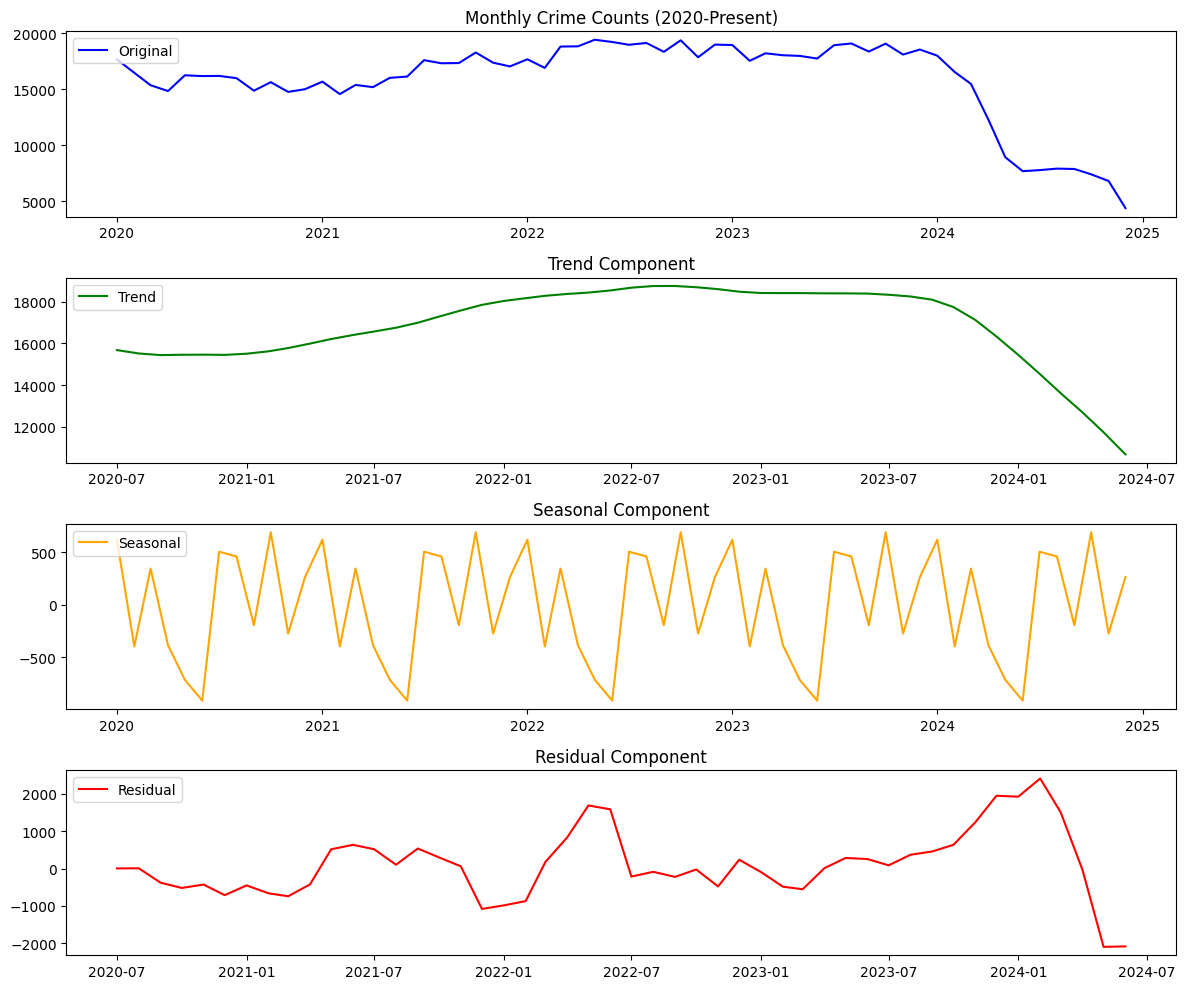

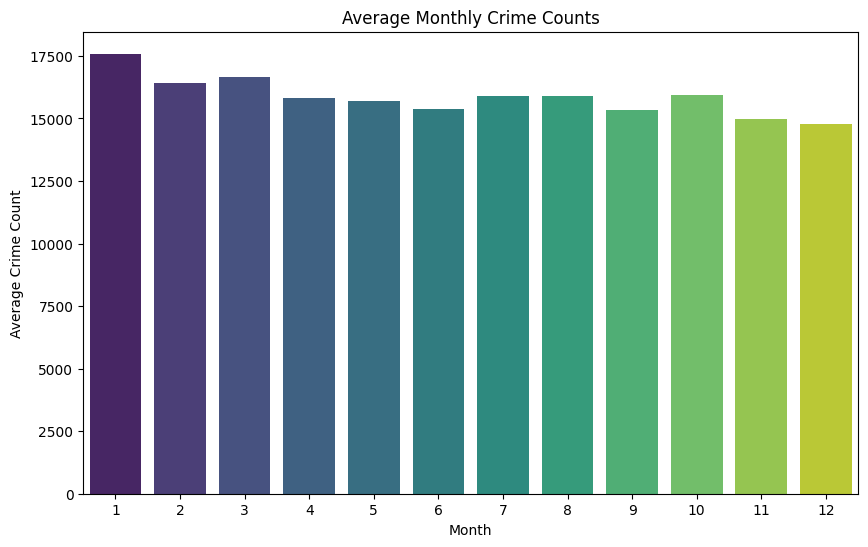

<Figure size 1000x600 with 0 Axes>

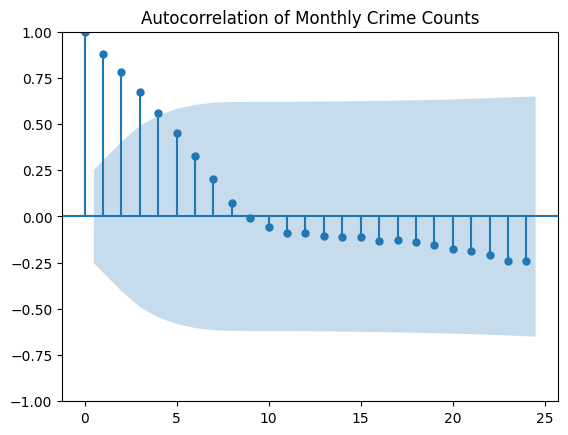

Top 5 Crimes by Year:
     Year                                        Crm Cd Desc  Count
0   2020                                   VEHICLE - STOLEN  19977
1   2020                           BATTERY - SIMPLE ASSAULT  15513
2   2020  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...  12272
3   2020                                           BURGLARY  12083
4   2020                              BURGLARY FROM VEHICLE  11930
5   2021                                   VEHICLE - STOLEN  22779
6   2021                           BATTERY - SIMPLE ASSAULT  15300
7   2021  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...  12965
8   2021                              BURGLARY FROM VEHICLE  12591
9   2021     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT  12184
10  2022                                   VEHICLE - STOLEN  23814
11  2022                                  THEFT OF IDENTITY  20783
12  2022                           BATTERY - SIMPLE ASSAULT  17320
13  2022                              B

In [6]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Load Preprocessed Data
df = pd.read_csv('Crime_Data_Cleaned_Advanced.csv')
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])

# Aggregate Crime Counts by Month
monthly_crimes = df.groupby(df['DATE OCC'].dt.to_period('M')).size().reset_index(name='Crime_Count')
monthly_crimes['DATE OCC'] = monthly_crimes['DATE OCC'].dt.to_timestamp()

# Set Index for Time Series Analysis
monthly_crimes.set_index('DATE OCC', inplace=True)

# Seasonal Decomposition (Period = 12 for Monthly Seasonality)
decomposition = seasonal_decompose(monthly_crimes['Crime_Count'], model='additive', period=12)

# Plot Decomposition
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(monthly_crimes['Crime_Count'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.title('Monthly Crime Counts (2020-Present)')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend(loc='upper left')
plt.title('Trend Component')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='orange')
plt.legend(loc='upper left')
plt.title('Seasonal Component')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend(loc='upper left')
plt.title('Residual Component')
plt.tight_layout()
plt.show()

# Seasonal Analysis by Month
monthly_avg = df.groupby('Month')['Crm Cd'].count() / df['Year'].nunique()
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette='viridis')
plt.title('Average Monthly Crime Counts')
plt.xlabel('Month')
plt.ylabel('Average Crime Count')
plt.show()

# Cyclic Patterns with Autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 6))
plot_acf(monthly_crimes['Crime_Count'], lags=24, title='Autocorrelation of Monthly Crime Counts')
plt.show()

top_crimes = df.groupby(['Year', 'Crm Cd Desc']).size().reset_index(name='Count')
top_crimes = top_crimes.groupby('Year').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True)
print("Top 5 Crimes by Year:\n", top_crimes)

print("Key Findings:")
print("- Trend: Long-term increase/decrease in crime rates.")
print("- Seasonal: Peaks in specific months (e.g., summer).")
print("- Cyclic: Recurring patterns visible in autocorrelation.")

R² Score: 0.546
RMSE: 152.087


C:\Users\R Manohar\AppData\Local\Temp\ipykernel_12240\3885200736.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='magma')


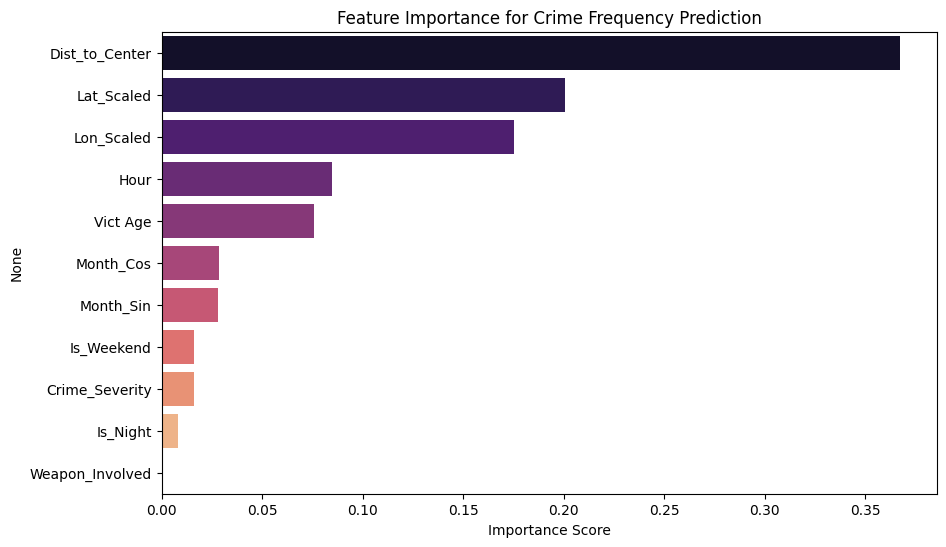

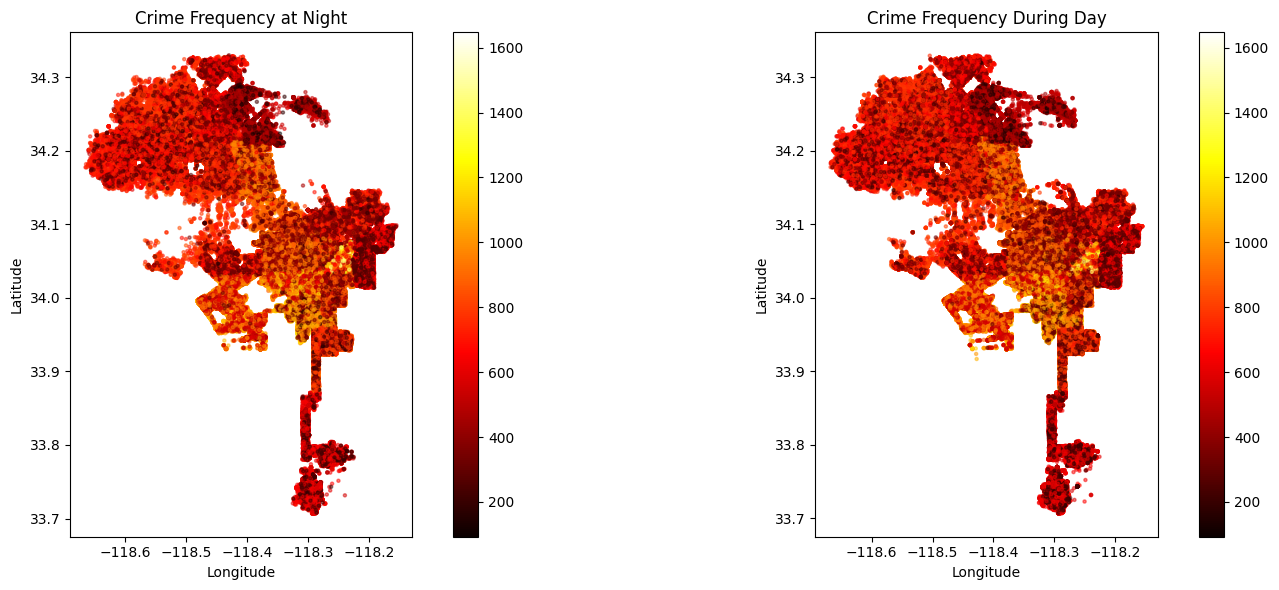

T-Test (Night vs. Day): t-statistic = 13.697, p-value = 0.000
Key Findings:
- Top spatial factors: ['Dist_to_Center', 'Lat_Scaled', 'Lon_Scaled']
- Top temporal factors: ['Hour']
- Night vs. Day Difference Significant: Yes (p=0.000)


In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import geopandas as gpd
from shapely.geometry import Point

# Load Preprocessed Data
df = pd.read_csv('Crime_Data_Cleaned_Advanced.csv')
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])

# Redefine Target: Crime Frequency per Area (Avoid Leakage with Geo_Cluster)
# Instead of Crime_Density (which is tied to Geo_Cluster), use crime counts per area as a proxy
df['Crime_Freq'] = df.groupby(['AREA', 'Year', 'Month'])['DR_NO'].transform('count')

# Features: Spatial and Temporal (Exclude Features Directly Tied to Target)
features = [
    'Lat_Scaled', 'Lon_Scaled', 'Dist_to_Center',  # Spatial
    'Hour', 'Is_Night', 'Is_Weekend', 'Month_Sin', 'Month_Cos',  # Temporal
    'Vict Age', 'Crime_Severity', 'Weapon_Involved'  # Contextual
]
target = 'Crime_Freq'

# Prepare Data
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluate Model
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

# Feature Importance
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette='magma')
plt.title('Feature Importance for Crime Frequency Prediction')
plt.xlabel('Importance Score')
plt.show()

# Geospatial Visualization with Temporal Overlay
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df['LON'], df['LAT'])])
gdf.crs = "EPSG:4326"

# Plot Crime Frequency by Area and Time (e.g., Night vs. Day)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
gdf[gdf['Is_Night'] == 1].plot(column='Crime_Freq', cmap='hot', markersize=5, alpha=0.5, ax=ax1, legend=True)
ax1.set_title('Crime Frequency at Night')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
gdf[gdf['Is_Night'] == 0].plot(column='Crime_Freq', cmap='hot', markersize=5, alpha=0.5, ax=ax2, legend=True)
ax2.set_title('Crime Frequency During Day')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

# Statistical Test: Compare Crime Frequency by Temporal Factors
from scipy.stats import ttest_ind
night_crimes = df[df['Is_Night'] == 1]['Crime_Freq']
day_crimes = df[df['Is_Night'] == 0]['Crime_Freq']
t_stat, p_value = ttest_ind(night_crimes, day_crimes, equal_var=False)
print(f"T-Test (Night vs. Day): t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

# Key Findings
spatial_factors = [f for f in importances.index[:5] if f in ['Lat_Scaled', 'Lon_Scaled', 'Dist_to_Center']]
temporal_factors = [f for f in importances.index[:5] if f in ['Hour', 'Is_Night', 'Is_Weekend', 'Month_Sin', 'Month_Cos']]
print("Key Findings:")
print(f"- Top spatial factors: {spatial_factors}")
print(f"- Top temporal factors: {temporal_factors}")
print(f"- Night vs. Day Difference Significant: {'Yes' if p_value < 0.05 else 'No'} (p={p_value:.3f})")

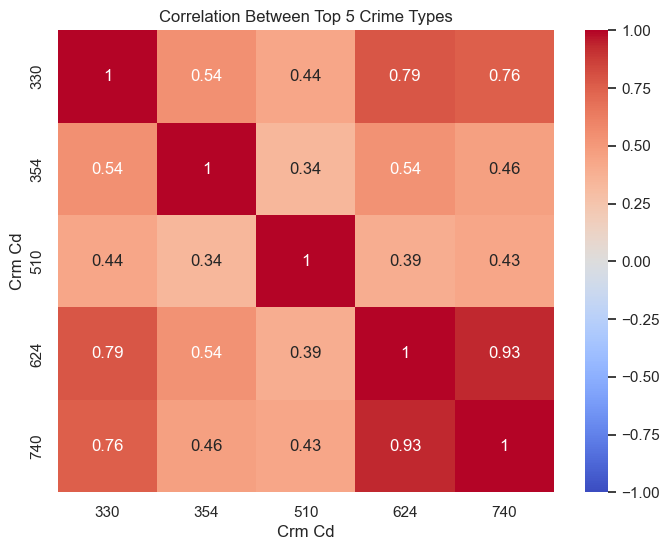


Granger Causality Test Results:

Testing if Crm Cd 510 Granger-causes Crm Cd 624:
Lag 1: Significant (p=0.0104)
Lag 2: Significant (p=0.0014)
Lag 3: Significant (p=0.0018)
Lag 4: Significant (p=0.0109)
Lag 5: Significant (p=0.0016)
Lag 6: Significant (p=0.0026)

Testing if Crm Cd 510 Granger-causes Crm Cd 330:
Lag 2: Significant (p=0.0415)

Testing if Crm Cd 510 Granger-causes Crm Cd 354:

Testing if Crm Cd 510 Granger-causes Crm Cd 740:
Lag 1: Significant (p=0.0047)
Lag 2: Significant (p=0.0028)
Lag 3: Significant (p=0.0112)
Lag 4: Significant (p=0.0179)
Lag 5: Significant (p=0.0260)
Lag 6: Significant (p=0.0357)

Testing if Crm Cd 624 Granger-causes Crm Cd 510:

Testing if Crm Cd 624 Granger-causes Crm Cd 330:

Testing if Crm Cd 624 Granger-causes Crm Cd 354:

Testing if Crm Cd 624 Granger-causes Crm Cd 740:
Lag 1: Significant (p=0.0290)

Testing if Crm Cd 330 Granger-causes Crm Cd 510:

Testing if Crm Cd 330 Granger-causes Crm Cd 624:
Lag 1: Significant (p=0.0046)
Lag 2: Significan

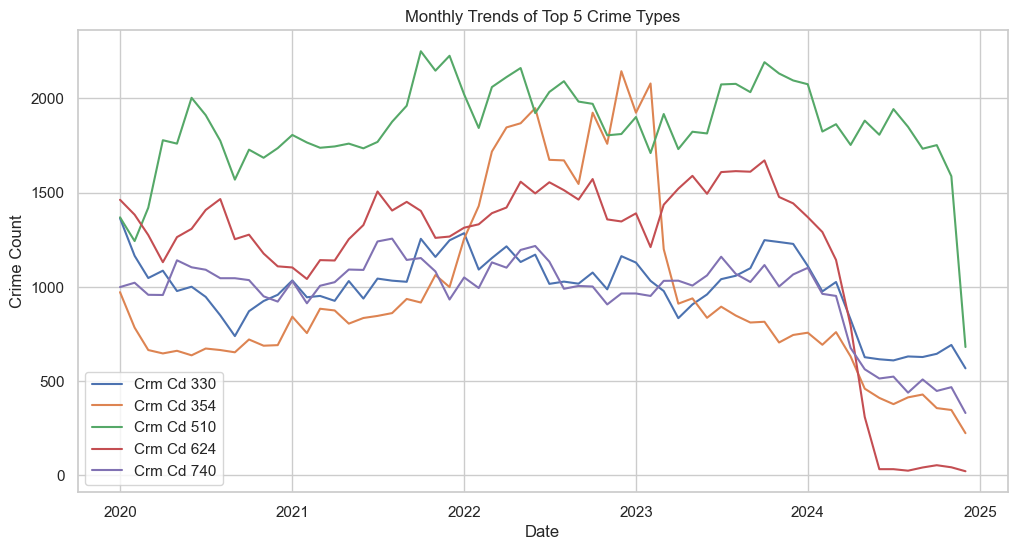


VAR Model Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 23, Mar, 2025
Time:                     08:43:50
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    49.5213
Nobs:                     42.0000    HQIC:                   45.4591
Log likelihood:          -1048.26    FPE:                4.22598e+19
AIC:                      43.1085    Det(Omega_mle):     2.66416e+18
--------------------------------------------------------------------
Results for equation 330
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const        213.252928      1009.186906            0.211           0.833
L1.330         0.403067         0.476132            0.847           0.397
L1.354        -0.028198         0.154727           -0.182           0.

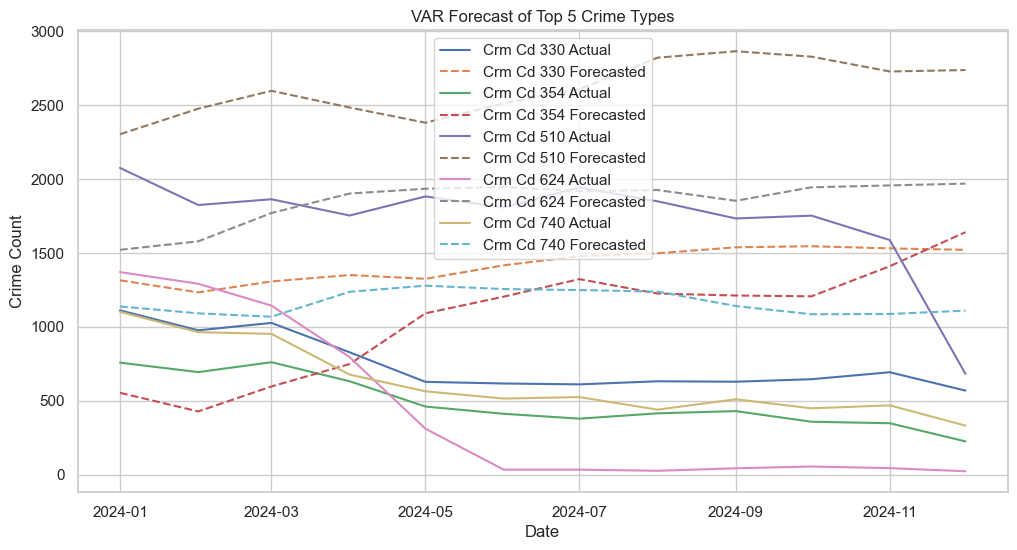


RMSE of VAR Forecast:
Crm Cd 330: 726.74
Crm Cd 354: 774.40
Crm Cd 510: 985.43
Crm Cd 624: 1567.55
Crm Cd 740: 602.82

Key Findings:
- Strong correlations indicate co-occurring crime types (see heatmap).
- Granger causality suggests predictive relationships (see significant pairs).
- VAR model captures temporal dependencies, with forecast accuracy shown by RMSE.


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
import warnings
warnings.filterwarnings('ignore')

# Load Preprocessed Data
df = pd.read_csv('Crime_Data_Cleaned_Advanced.csv')
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])

# Aggregate Crime Types by Month
top_crimes = df['Crm Cd'].value_counts().head(5).index  # Top 5 crime types
monthly_data = df[df['Crm Cd'].isin(top_crimes)].groupby([df['DATE OCC'].dt.to_period('M'), 'Crm Cd']).size().unstack(fill_value=0)
monthly_data.index = monthly_data.index.to_timestamp()

# Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(monthly_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Top 5 Crime Types')
plt.show()

# Granger Causality Test
max_lag = 6
print("\nGranger Causality Test Results:")
significant_causality = []
for col1 in top_crimes:
    for col2 in top_crimes:
        if col1 != col2:
            print(f"\nTesting if Crm Cd {col1} Granger-causes Crm Cd {col2}:")
            results = grangercausalitytests(monthly_data[[col1, col2]], max_lag, verbose=False)
            for lag in range(1, max_lag + 1):
                p_value = results[lag][0]['ssr_ftest'][1]
                if p_value < 0.05:
                    print(f"Lag {lag}: Significant (p={p_value:.4f})")
                    significant_causality.append((col1, col2, lag, p_value))

# Plot Time Series of Top Crimes
plt.figure(figsize=(12, 6))
for col in monthly_data.columns:
    plt.plot(monthly_data.index, monthly_data[col], label=f'Crm Cd {col}')
plt.title('Monthly Trends of Top 5 Crime Types')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()
plt.show()

# Predictive Modeling with VAR (Vector Autoregression)
# Prepare Data for VAR
train_size = int(len(monthly_data) * 0.8)
train_data = monthly_data[:train_size]
test_data = monthly_data[train_size:]

# Fit VAR Model
model = VAR(train_data)
var_result = model.fit(maxlags=6, ic='aic')
print("\nVAR Model Summary:")
print(var_result.summary())

# Forecast
forecast = var_result.forecast(train_data.values[-var_result.k_ar:], steps=len(test_data))
forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=test_data.columns)

# Plot Actual vs Forecasted
plt.figure(figsize=(12, 6))
for col in monthly_data.columns:
    plt.plot(test_data.index, test_data[col], label=f'Crm Cd {col} Actual')
    plt.plot(forecast_df.index, forecast_df[col], '--', label=f'Crm Cd {col} Forecasted')
plt.title('VAR Forecast of Top 5 Crime Types')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()
plt.show()

# Evaluate Forecast
from sklearn.metrics import mean_squared_error
rmse = {}
for col in monthly_data.columns:
    rmse[col] = np.sqrt(mean_squared_error(test_data[col], forecast_df[col]))
print("\nRMSE of VAR Forecast:")
for col, value in rmse.items():
    print(f"Crm Cd {col}: {value:.2f}")

print("\nKey Findings:")
print("- Strong correlations indicate co-occurring crime types (see heatmap).")
print("- Granger causality suggests predictive relationships (see significant pairs).")
print("- VAR model captures temporal dependencies, with forecast accuracy shown by RMSE.")

Geo_Cluster Distribution:
Geo_Cluster
0    951957
Name: count, dtype: int64
Top 5 Clusters: [0]
Valid Clusters for Prediction: [0]


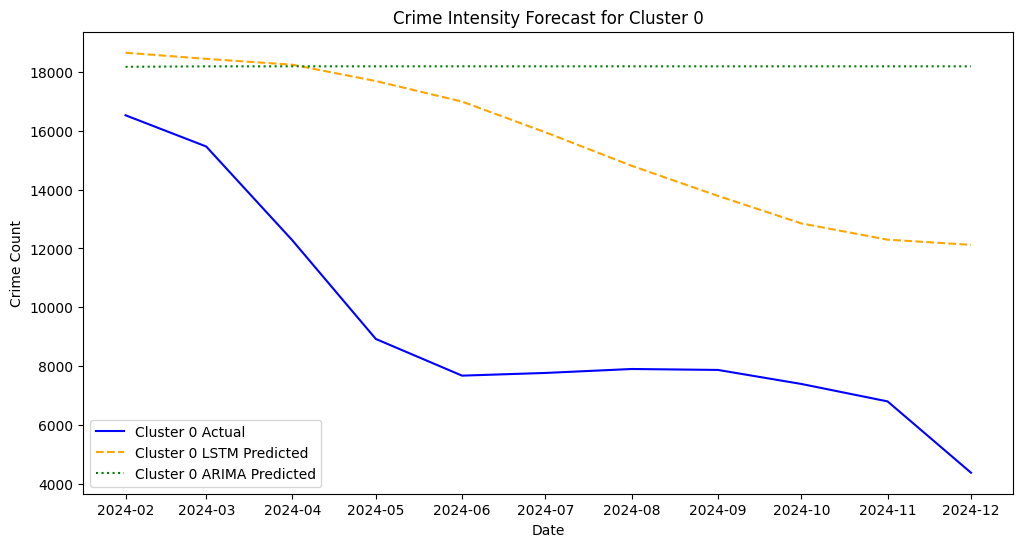

Model Performance Metrics:

Cluster 0:
LSTM - MAE: 6264.04, RMSE: 6625.72, MAPE: 81.88%
ARIMA - MAE: 8832.81, RMSE: 9539.02, MAPE: 122.05%

High-Risk Periods for Proactive Policing:

Cluster 0:
High-Risk Periods (Predicted Crime Count >= 75th Percentile):
        Date     Predicted
0 2024-02-01  18658.277344
1 2024-03-01  18449.435547
2 2024-04-01  18250.582031


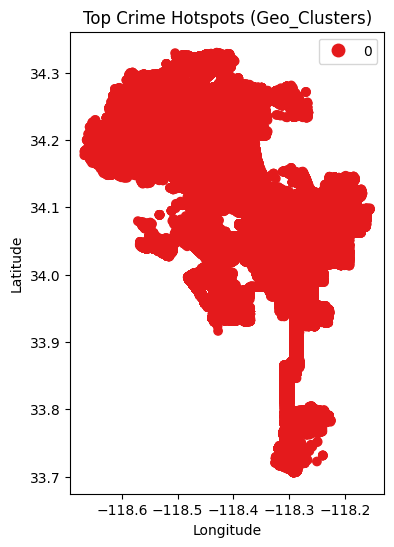

Key Findings:
- LSTM and ARIMA models predict crime intensities within hotspots (see metrics).
- High-risk periods identified for each hotspot can guide proactive policing (see tables).
- Spatial distribution of hotspots visualized for resource deployment (see map).


In [11]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import geopandas as gpd
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

# Load Preprocessed Data
df = pd.read_csv('Crime_Data_Cleaned_Advanced.csv')
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])

# Check Geo_Cluster Distribution and Select Top Clusters
print("Geo_Cluster Distribution:")
cluster_counts = df['Geo_Cluster'].value_counts()
print(cluster_counts)

# Exclude noise points (-1) and select top 5 clusters
top_clusters = cluster_counts.index[cluster_counts.index != -1][:5]
print(f"Top 5 Clusters: {top_clusters.tolist()}")

# Aggregate by Cluster and Month
monthly_cluster = df[df['Geo_Cluster'].isin(top_clusters)].groupby(
    [df['DATE OCC'].dt.to_period('M'), 'Geo_Cluster']
).size().unstack(fill_value=0)
monthly_cluster.index = monthly_cluster.index.to_timestamp()

# Ensure Enough Data for Each Cluster
min_data_points = 12  # Require at least 12 months of data
valid_clusters = monthly_cluster.columns[
    (monthly_cluster > 0).sum() >= min_data_points
]
if len(valid_clusters) == 0:
    print("No clusters have enough data for time-series prediction. Adjust DBSCAN parameters.")
else:
    print(f"Valid Clusters for Prediction: {valid_clusters.tolist()}")
    monthly_top = monthly_cluster[valid_clusters]

    # Prepare Time-Series Data for LSTM
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length])
            y.append(data[i + seq_length])
        return np.array(X), np.array(y)

    seq_length = 6  # Use 6 months to predict the next
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(monthly_top)

    # Initialize Dictionaries for Results
    lstm_predictions = {}
    lstm_actuals = {}
    lstm_metrics = {}
    arima_predictions = {}
    arima_actuals = {}
    arima_metrics = {}

    # Forecast for Each Cluster
    for i, cluster in enumerate(valid_clusters):
        cluster_data = scaled_data[:, i]
        if len(cluster_data.nonzero()[0]) < seq_length + 1:
            print(f"Skipping Cluster {cluster}: Not enough non-zero data points.")
            continue

        # Prepare Data for LSTM
        X, y = create_sequences(cluster_data, seq_length)
        train_size = int(len(X) * 0.8)
        if train_size < 10:
            print(f"Skipping Cluster {cluster}: Not enough data for training.")
            continue
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # --- LSTM Model ---
        model = Sequential([
            LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
            Dropout(0.3),
            LSTM(50, activation='relu'),
            Dropout(0.3),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        model.fit(X_train_lstm, y_train, epochs=50, batch_size=16, verbose=0, validation_split=0.2)
        y_pred_lstm = model.predict(X_test_lstm, verbose=0)
        y_pred_lstm_unscaled = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()
        y_test_lstm_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

        # --- ARIMA Model (Baseline) ---
        cluster_data_unscaled = monthly_top[cluster].values
        train_data_arima = cluster_data_unscaled[:train_size + seq_length]
        test_data_arima = cluster_data_unscaled[train_size + seq_length:]
        arima_model = ARIMA(train_data_arima, order=(1, 1, 1))  # Simple ARIMA model
        arima_fit = arima_model.fit()
        arima_forecast = arima_fit.forecast(steps=len(test_data_arima))
        y_pred_arima = arima_forecast  # Remove .values since arima_forecast is already a numpy array

        # Store Results
        lstm_predictions[cluster] = y_pred_lstm_unscaled
        lstm_actuals[cluster] = y_test_lstm_unscaled
        arima_predictions[cluster] = y_pred_arima
        arima_actuals[cluster] = test_data_arima

        # Calculate Metrics
        def calculate_metrics(actual, predicted):
            mae = mean_absolute_error(actual, predicted)
            rmse = np.sqrt(mean_squared_error(actual, predicted))
            # Avoid division by zero in MAPE
            mape = np.mean(np.abs((actual - predicted) / actual)) * 100 if not np.any(actual == 0) else float('inf')
            return mae, rmse, mape

        lstm_metrics[cluster] = calculate_metrics(y_test_lstm_unscaled, y_pred_lstm_unscaled)
        arima_metrics[cluster] = calculate_metrics(test_data_arima, y_pred_arima)

    # Plot Predictions for Each Cluster
    if lstm_predictions:
        for cluster in lstm_predictions.keys():
            plt.figure(figsize=(12, 6))
            plt.plot(monthly_top.index[-len(lstm_actuals[cluster]):], lstm_actuals[cluster], 
                     label=f'Cluster {cluster} Actual', color='blue')
            plt.plot(monthly_top.index[-len(lstm_predictions[cluster]):], lstm_predictions[cluster], 
                     '--', label=f'Cluster {cluster} LSTM Predicted', color='orange')
            plt.plot(monthly_top.index[-len(arima_actuals[cluster]):], arima_predictions[cluster], 
                     ':', label=f'Cluster {cluster} ARIMA Predicted', color='green')
            plt.title(f'Crime Intensity Forecast for Cluster {cluster}')
            plt.xlabel('Date')
            plt.ylabel('Crime Count')
            plt.legend()
            plt.show()

        # Evaluate and Compare Models
        print("Model Performance Metrics:")
        for cluster in lstm_predictions.keys():
            print(f"\nCluster {cluster}:")
            print(f"LSTM - MAE: {lstm_metrics[cluster][0]:.2f}, RMSE: {lstm_metrics[cluster][1]:.2f}, MAPE: {lstm_metrics[cluster][2]:.2f}%")
            print(f"ARIMA - MAE: {arima_metrics[cluster][0]:.2f}, RMSE: {arima_metrics[cluster][1]:.2f}, MAPE: {arima_metrics[cluster][2]:.2f}%")

        # Identify High-Risk Periods for Policing
        print("\nHigh-Risk Periods for Proactive Policing:")
        for cluster in lstm_predictions.keys():
            pred_df = pd.DataFrame({
                'Date': monthly_top.index[-len(lstm_predictions[cluster]):],
                'Predicted': lstm_predictions[cluster]
            })
            high_risk_threshold = np.percentile(lstm_predictions[cluster], 75)  # Top 25% of predictions
            high_risk_periods = pred_df[pred_df['Predicted'] >= high_risk_threshold]
            print(f"\nCluster {cluster}:")
            print("High-Risk Periods (Predicted Crime Count >= 75th Percentile):")
            print(high_risk_periods[['Date', 'Predicted']])

        # Visualize Hotspots
        gdf = gpd.GeoDataFrame(df[df['Geo_Cluster'].isin(valid_clusters)], 
                               geometry=[Point(xy) for xy in zip(df['LON'], df['LAT'])])
        gdf.crs = "EPSG:4326"
        gdf.plot(column='Geo_Cluster', categorical=True, legend=True, figsize=(10, 6), cmap='Set1')
        plt.title('Top Crime Hotspots (Geo_Clusters)')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()

        print("Key Findings:")
        print("- LSTM and ARIMA models predict crime intensities within hotspots (see metrics).")
        print("- High-risk periods identified for each hotspot can guide proactive policing (see tables).")
        print("- Spatial distribution of hotspots visualized for resource deployment (see map).")
    else:
        print("No valid clusters for prediction. Please revisit DBSCAN clustering.")